In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read dataset
df = pd.read_csv('01_listings_summary_dec18.csv')

## Exploratory Data Analysis (EDA)

### Data Overview & Summary Statistics

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 84 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22895 non-null  int64  
 1   listing_url                       22895 non-null  object 
 2   scrape_id                         22895 non-null  float64
 3   last_scraped                      22895 non-null  object 
 4   name                              22892 non-null  object 
 5   summary                           22199 non-null  object 
 6   space                             16844 non-null  object 
 7   description                       22563 non-null  object 
 8   neighborhood_overview             14424 non-null  object 
 9   notes                             11544 non-null  object 
 10  transit                           14943 non-null  object 
 11  access                            15168 non-null  object 
 12  inte

In [4]:
df.describe()

id     scrape_id       host_id      latitude     longitude  \
count  2.289500e+04  2.289500e+04  2.289500e+04  22895.000000  22895.000000   
mean   1.869883e+07  2.018120e+13  7.083412e+07    -37.826827    145.008457   
std    8.141522e+06  0.000000e+00  6.471893e+07      0.066747      0.127711   
min    9.835000e+03  2.018120e+13  9.082000e+03    -38.224427    144.484326   
25%    1.287570e+07  2.018120e+13  1.728005e+07    -37.852665    144.957692   
50%    2.026177e+07  2.018120e+13  4.801411e+07    -37.817855    144.978402   
75%    2.495525e+07  2.018120e+13  1.143842e+08    -37.803176    145.013441   
max    3.059362e+07  2.018120e+13  2.294705e+08    -37.482595    145.839127   

       accommodates     bathrooms      bedrooms          beds         price  \
count  22895.000000  22878.000000  22890.000000  22861.000000  22895.000000   
mean       3.435554      1.291590      1.527741      1.990027    148.004368   
std        2.228580      0.579754      0.948241      1.539957    210.883253   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      1.000000      1.000000     71.000000   
50%        2.000000      1.000000      1.000000      1.000000    111.000000   
75%        4.000000      1.500000      2.000000      2.000000    165.000000   
max       16.000000     14.000000     16.000000     24.000000  12624.000000   

       ...  number_of_reviews  review_scores_rating  review_scores_accuracy  \
count  ...       22895.000000          17189.000000            17175.000000   
mean   ...          21.266477             94.182791                9.634003   
std    ...          39.013606              8.567504                0.842954   
min    ...           0.000000             20.000000                2.000000   
25%    ...           1.000000             92.000000                9.000000   
50%    ...           5.000000             97.000000               10.000000   
75%    ...          23.500000            100.000000               10.000000   
max    ...         538.000000            100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               17182.000000           17161.000000   
mean                    9.425154               9.718548   
std                     0.999716               0.771604   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                 17177.000000            17162.000000   
mean                      9.750073                9.714078   
std                       0.764552                0.697961   
min                       2.000000                2.000000   
25%                      10.000000               10.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  calculated_host_listings_count  reviews_per_month  
count         17160.000000                    22895.000000       17653.000000  
mean              9.478205                        7.125792           1.590542  
std               0.892818                       15.637804           1.724118  
min               2.000000                        1.000000           0.010000  
25%               9.000000                        1.000000           0.300000  
50%              10.000000                        1.000000           1.000000  
75%              10.000000                        4.000000           2.290000  
max              10.000000                       98.000000          14.540000  

[8 rows x 32 columns]

In [5]:
# Remove irrelevant columns such as ID, URL, and name-related columns
irrelevant_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped',
    'interaction',  'host_id', 'host_url', 'host_name', 'host_location',
    'host_thumbnail_url', 'host_picture_url', 'picture_url', 'host_verifications',
    'name', 'last_review', 'first_review', 'reviews_per_month', 'zipcode', 'street', 'suburb',
    'neighborhood', 'is_location_exact', 'amenities', "host_about", "city", "host_response_time",
    'country', 'state', 'calendar_last_scraped', 'calendar_updated', 'country_code'
]

# Drop the specified columns if they exist in the dataset
data = df.drop(columns=[col for col in irrelevant_cols if col in df.columns])

# Display the shape of the cleaned dataset
data.shape


(22895, 53)

In [6]:
# Check duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows in train dataset: {duplicate_rows}")
if duplicate_rows > 0:
    data = data.drop_duplicates()
    print("Duplicate rows removed from train dataset.")

Number of duplicate rows in train dataset: 0


### Missing Data Analysis

In [7]:
# List all the columns with missing values
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_percentage = (missing_data / len(data)) * 100

missing_data_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

missing_data_df

Missing Values  Percentage
license                               22874   99.908277
monthly_price                         21004   91.740555
weekly_price                          20371   88.975759
notes                                 11351   49.578511
neighborhood_overview                  8471   36.999345
host_neighborhood                      7968   34.802359
transit                                7952   34.732474
house_rules                            7863   34.343743
access                                 7727   33.749727
security_deposit                       7494   32.732038
host_response_rate                     7306   31.910898
space                                  6051   26.429351
review_scores_value                    5735   25.049137
review_scores_checkin                  5734   25.044770
review_scores_location                 5733   25.040402
review_scores_accuracy                 5720   24.983621
review_scores_communication            5718   24.974885
review_scores_cleanliness              5713   24.953047
review_scores_rating                   5706   24.922472
cleaning_fee                           5646   24.660406
summary                                 696    3.039965
description                             332    1.450098
beds                                     34    0.148504
bathrooms                                17    0.074252
bedrooms                                  5    0.021839
host_has_profile_pic                      3    0.013103
host_is_superhost                         3    0.013103
host_since                                3    0.013103
host_identity_verified                    3    0.013103

### Outliers Detection

In [8]:
# Construct numerical columns
num_cols = data.select_dtypes(include=['number'])

# Analyse the potential outliers
outlier_dict = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    # Store results
    outlier_dict[col] = {
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": len(outliers),
        "Outlier Percentage": (len(outliers) / len(df)) * 100,
    }

# Convert results to a DataFrame for better visualization
outlier_df = pd.DataFrame.from_dict(outlier_dict, orient="index")
print(outlier_df)

outlier_cols = outlier_df[outlier_df["Outlier Percentage"] > 0].index

                                Lower Bound  Upper Bound  Outlier Count  \
latitude                         -37.926898   -37.728943           2201   
longitude                        144.874069   145.097065           4249   
accommodates                      -1.000000     7.000000           1251   
bathrooms                          0.250000     2.250000           1258   
bedrooms                          -0.500000     3.500000            972   
beds                              -0.500000     3.500000           2711   
price                            -70.000000   306.000000           1445   
weekly_price                    -474.000000  1990.000000            156   
monthly_price                  -1618.750000  7231.250000             93   
security_deposit                -267.500000   800.500000            916   
cleaning_fee                     -72.500000   187.500000            515   
guests_included                   -0.500000     3.500000           3442   
extra_people             

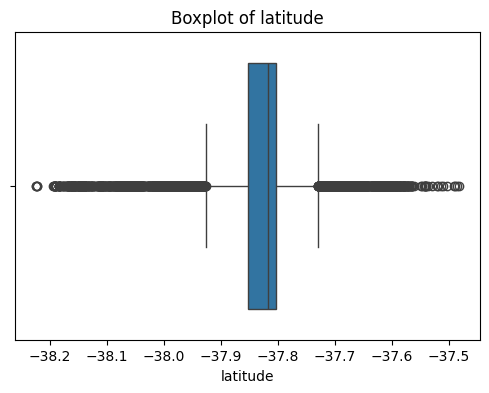

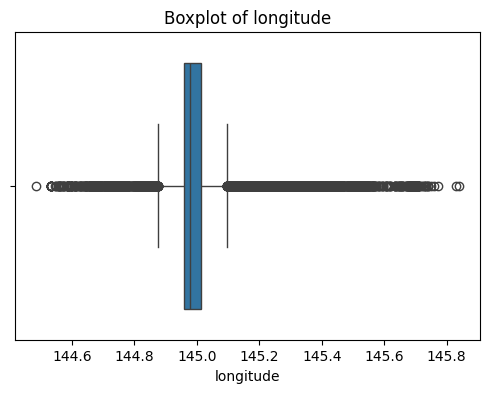

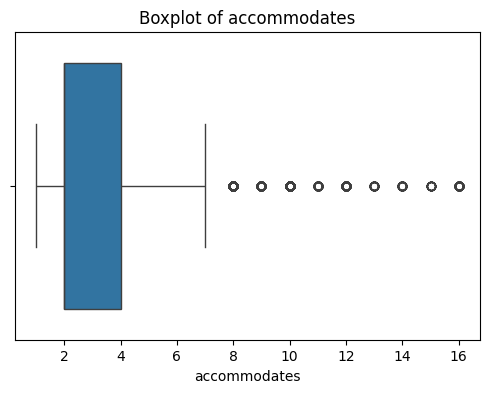

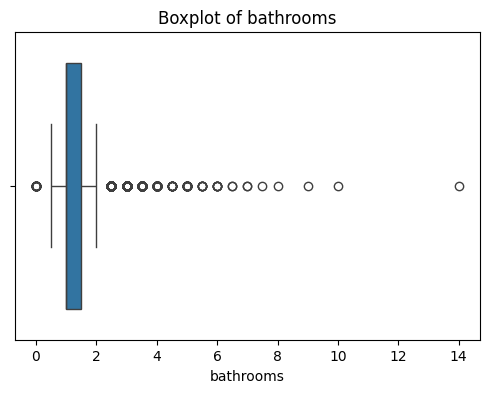

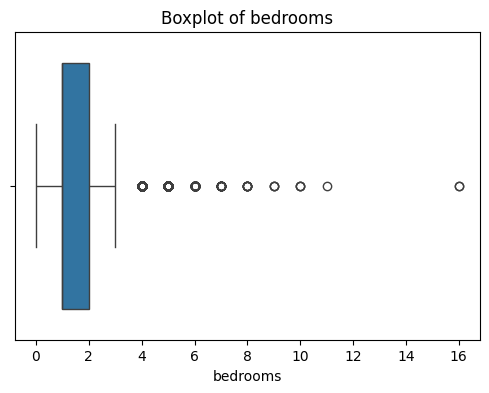

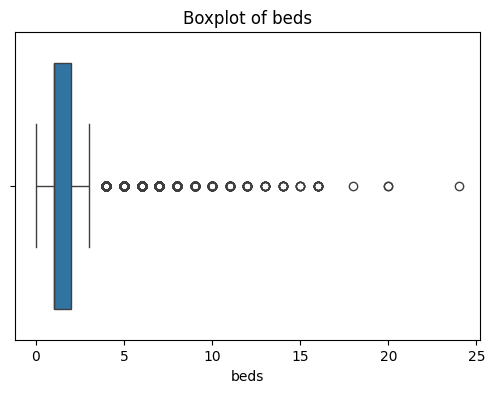

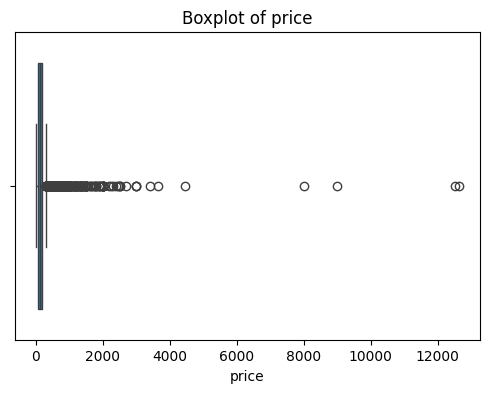

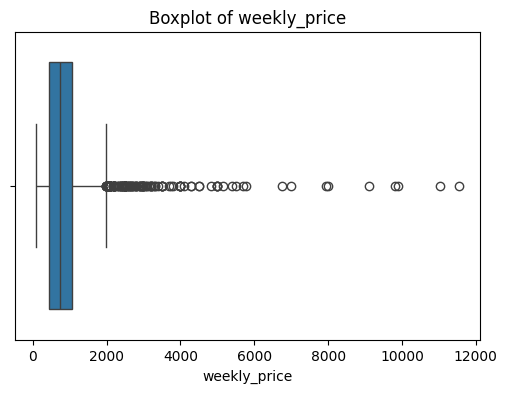

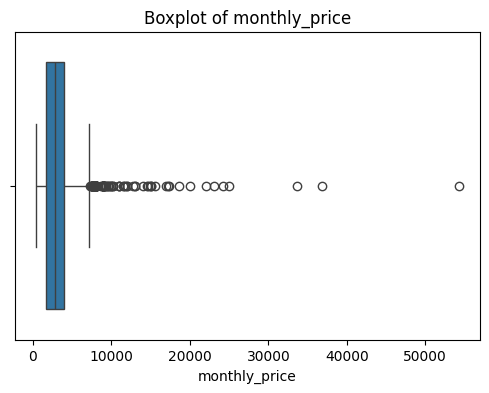

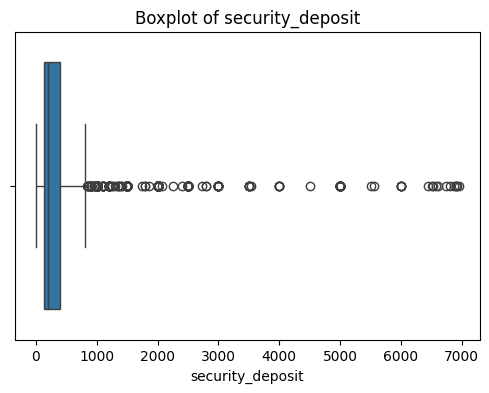

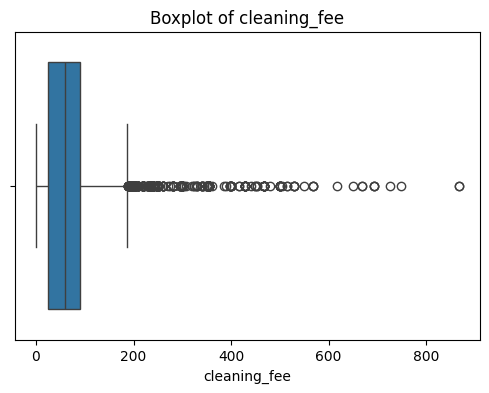

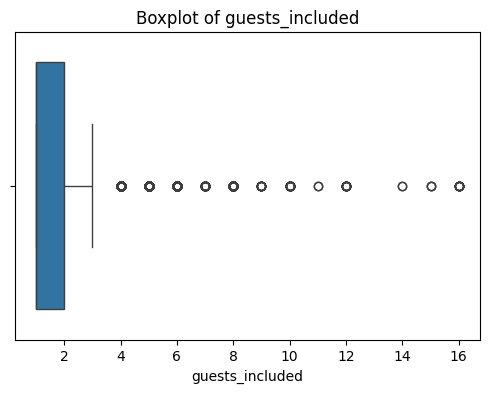

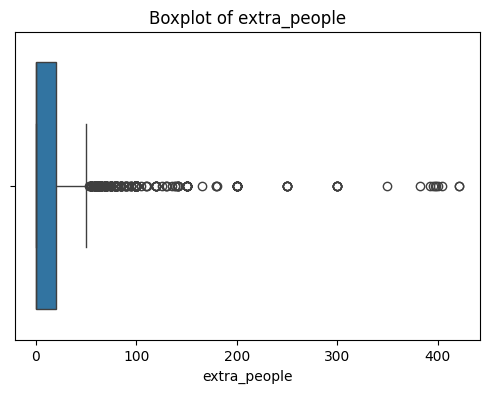

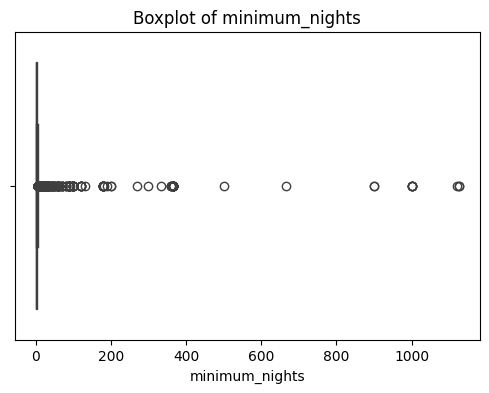

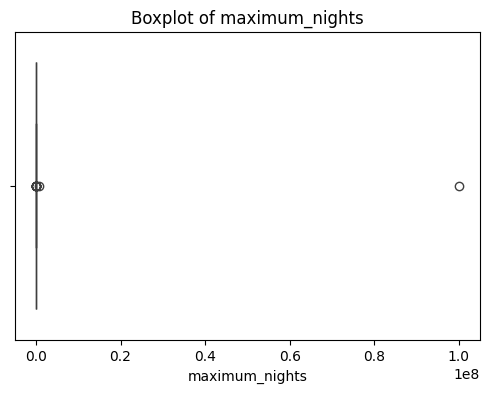

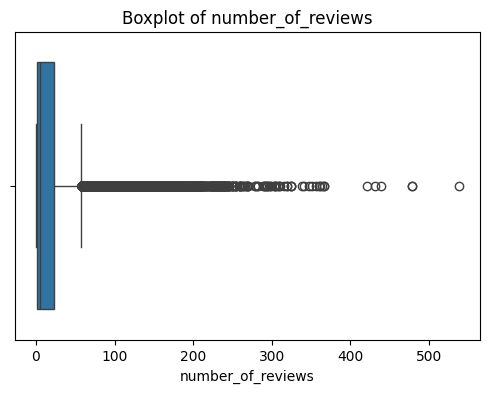

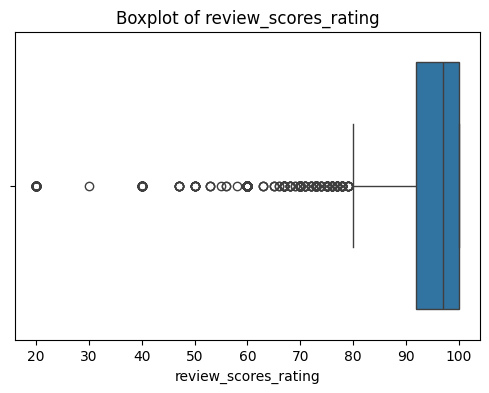

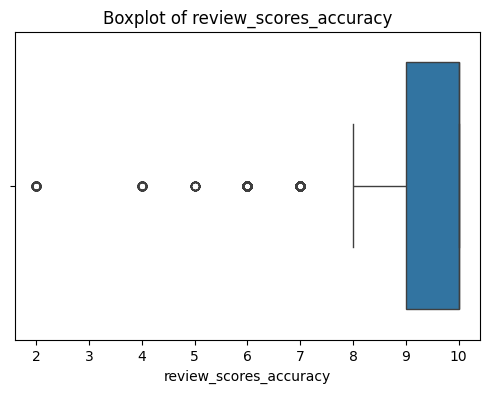

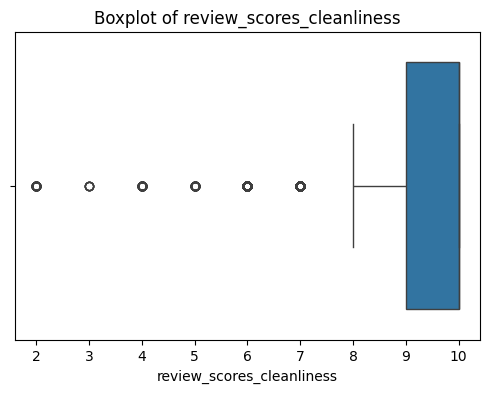

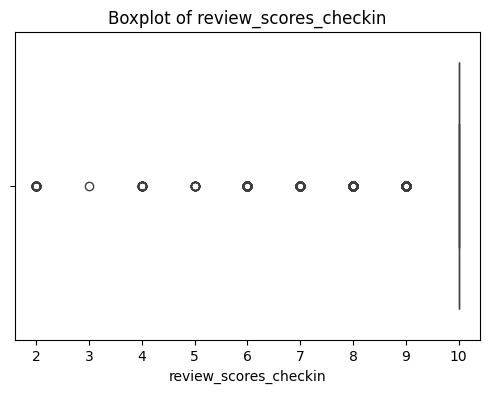

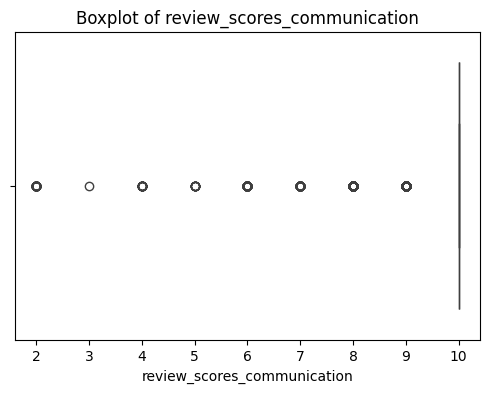

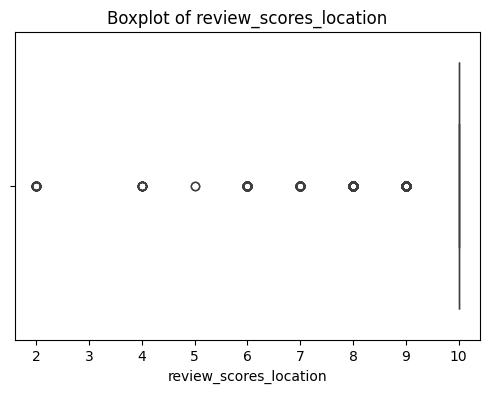

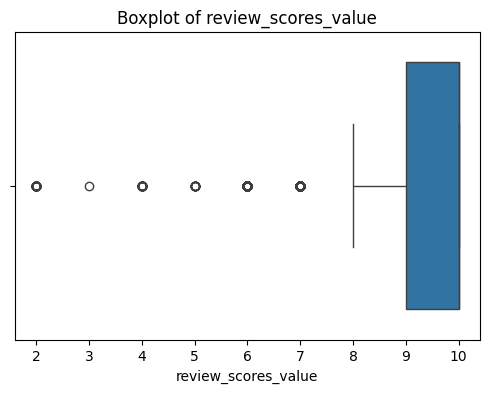

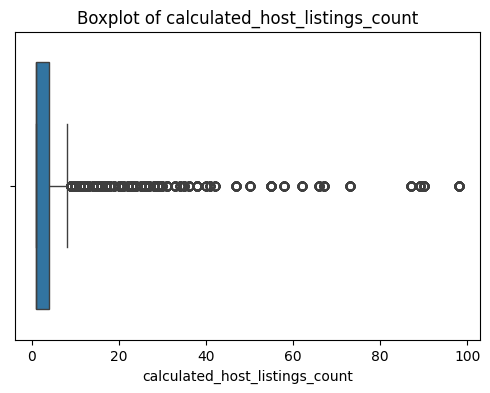

In [9]:
# Draw the boxplot for columns with potential outliers
for col in outlier_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()


### Correlation Analysis

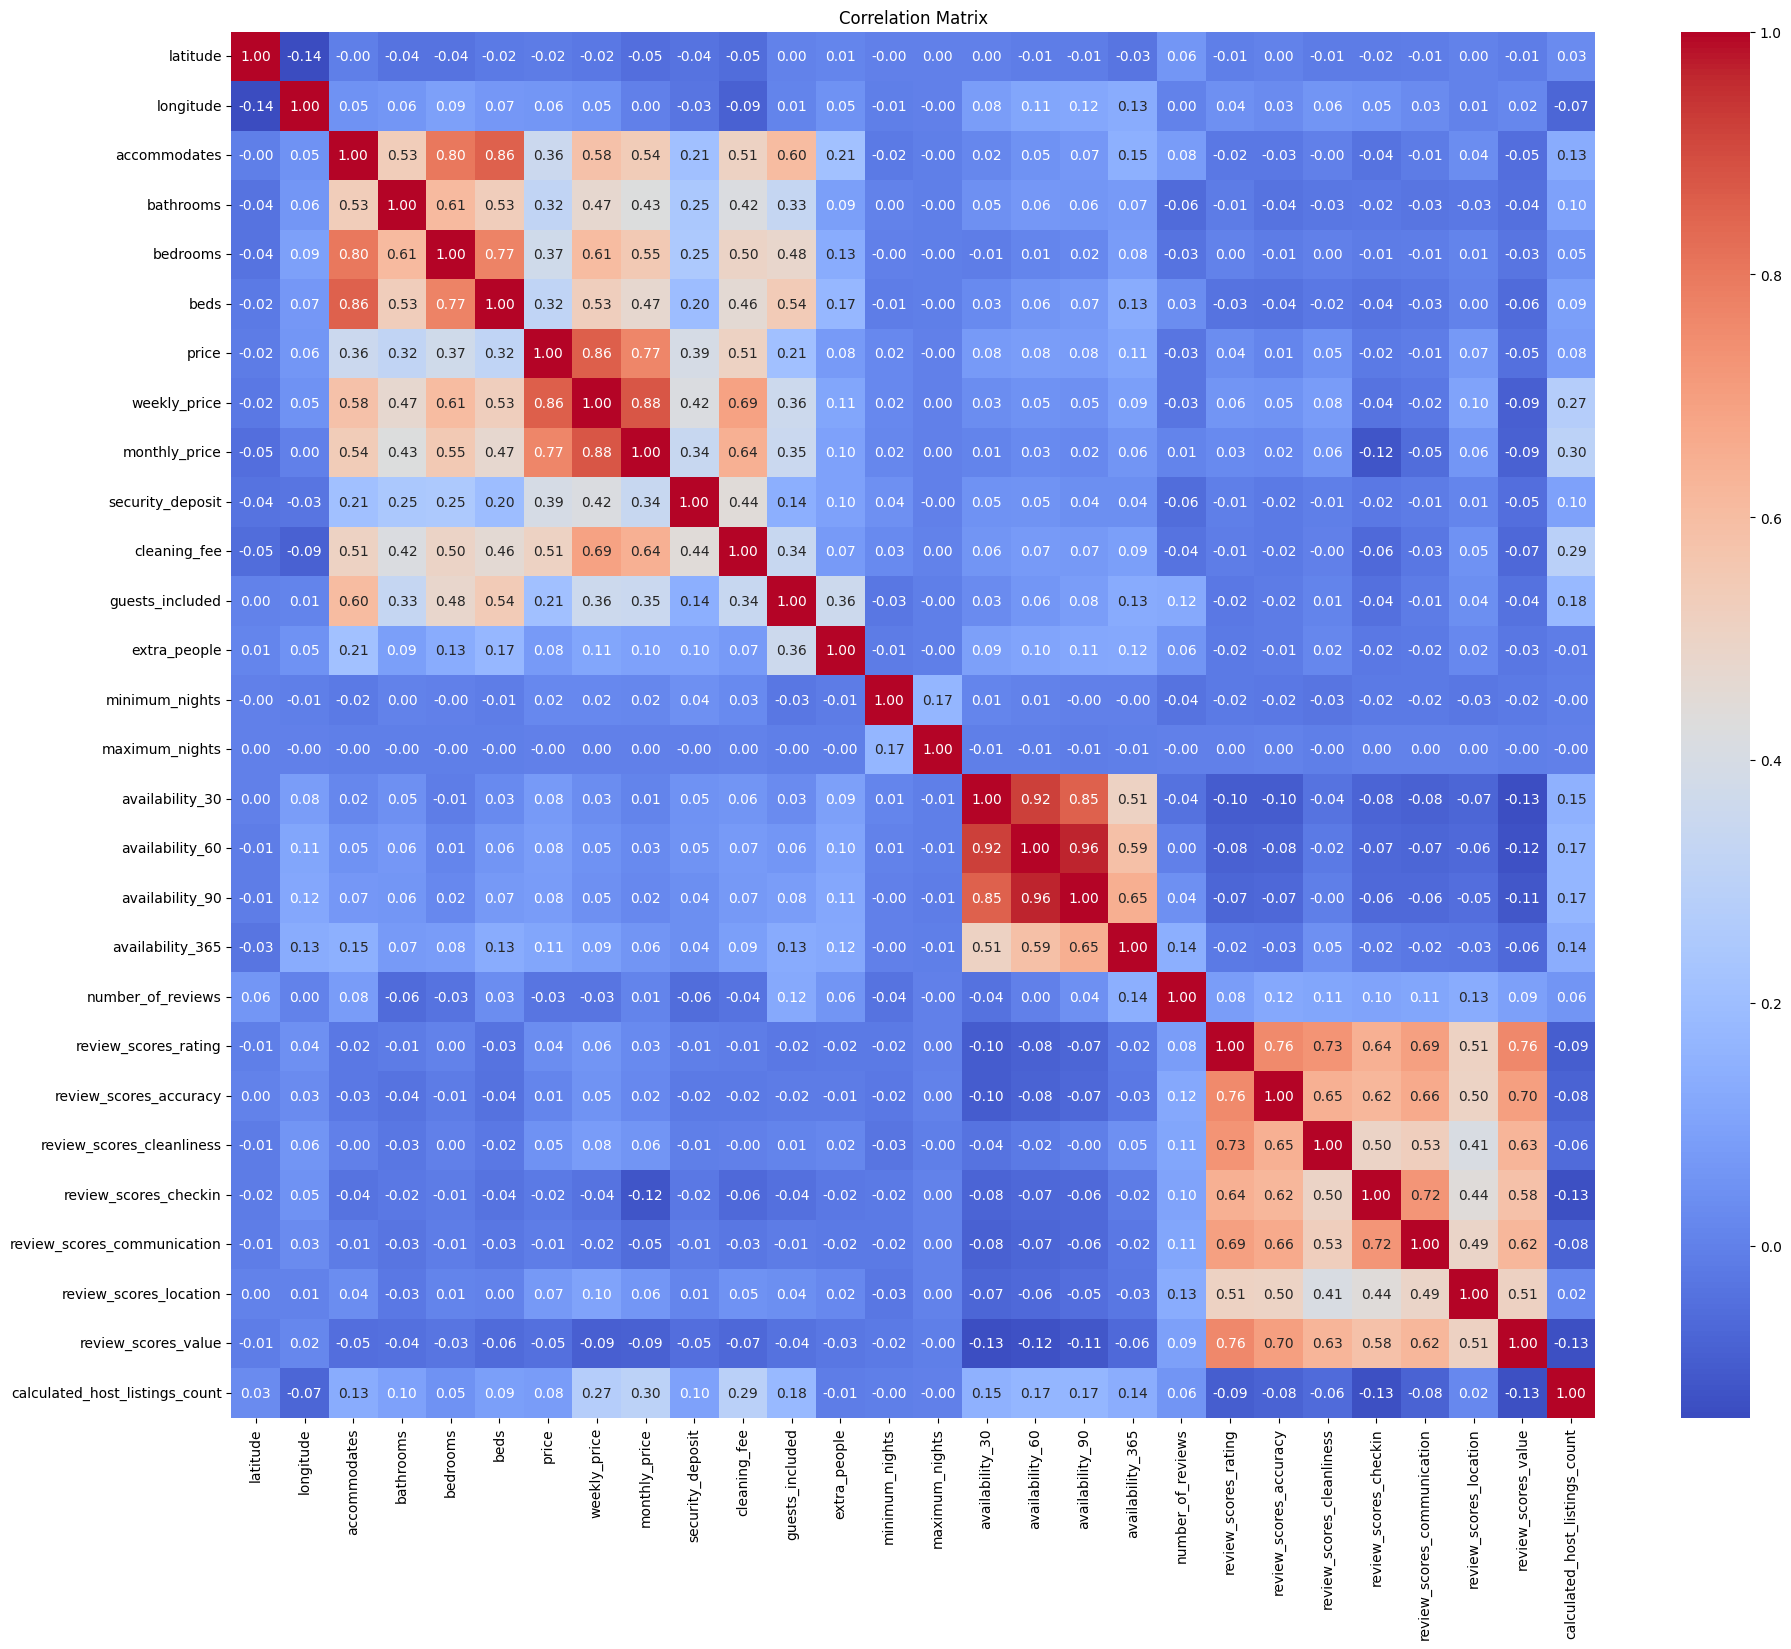

In [10]:
# Analyze the correlation between variables
correlation_matrix = num_cols.corr()
plt.figure(figsize=(22,18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Data Preparation

### Handling Missing Values

In [11]:
# Handle missing values
# Drop entire columns
columns_to_drop = [
    "license", "monthly_price", "weekly_price", "host_neighborhood", "access",
    "space", "host_verifications"
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Drop rows where review score columns have missing values
review_score_columns = [
    "review_scores_value", "review_scores_checkin", "review_scores_location",
    "review_scores_accuracy", "review_scores_communication",
    "review_scores_cleanliness", "review_scores_rating"
]
data = data.dropna(subset=review_score_columns)

# Drop rows where some columns with very low missing rates have missing values
low_missing_rate_columns = [
    "beds", "bathrooms", "host_since", "host_is_superhost",
    "host_has_profile_pic", "host_identity_verified", "bedrooms"
]
data = data.dropna(subset=low_missing_rate_columns)

# Fill missing values with "" (empty string) for specified categorical variables
fill_empty_columns = ["summary", "description"]

data[fill_empty_columns] = data[fill_empty_columns].fillna("")

# Fill missing values for some columns with 0
fill_zero_columns = [
    "transit", "notes", "neighborhood_overview", "house_rules",
    "host_response_rate", "cleaning_fee", "security_deposit"
]
data[fill_zero_columns] = data[fill_zero_columns].fillna(0)

# Display the updated dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17137 entries, 0 to 22607
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   summary                           17137 non-null  object 
 1   description                       17137 non-null  object 
 2   neighborhood_overview             17137 non-null  object 
 3   notes                             17137 non-null  object 
 4   transit                           17137 non-null  object 
 5   house_rules                       17137 non-null  object 
 6   host_since                        17137 non-null  object 
 7   host_response_rate                17137 non-null  object 
 8   host_is_superhost                 17137 non-null  object 
 9   host_has_profile_pic              17137 non-null  object 
 10  host_identity_verified            17137 non-null  object 
 11  smart_location                    17137 non-null  object 
 12  latitude 

### Handling Outliers

In [12]:
# Handle outliers
# Set minimum for potential outliers columns
data['accommodates'] = data['accommodates'].clip(lower=1)
data['price'] = data['price'].clip(lower=10)

columns_lower_0 = [
    "bathrooms", "bedrooms", "beds", "security_deposit",
    "cleaning_fee", "extra_people", "number_of_reviews"
]
data[columns_lower_0] = data[columns_lower_0].clip(lower=0)

columns_lower_1 = [
    "guests_included", "minimum_nights", "maximum_nights",
    "calculated_host_listings_count"
]
data[columns_lower_1] = data[columns_lower_1].clip(lower=1)

review_score_columns = [
    "review_scores_accuracy",
    "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location",
    "review_scores_value"
]
data[review_score_columns] = data[review_score_columns].clip(lower=0, upper=10)

# Set a reasonable upper limit (e.g., 99th percentile)
upper_limit = data["maximum_nights"].quantile(0.99)

# Replace values exceeding the upper limit with the set threshold
data.loc[data["maximum_nights"] > upper_limit, "maximum_nights"] = upper_limit


print(f"Shape after Cleaning: {data.shape}")

Shape after Cleaning: (17137, 47)


### Handling Highly Correlated Variables

In [13]:
# According to heatmap above, drop highly correlated variables
# availability_30, availability_60, and availability_365 are highly correlated with availability_90
# weekly_price and monthly_price are highly correlated with price
data = data.drop(columns=["availability_30", "availability_60", "availability_365", "weekly_price", "monthly_price"], errors='ignore')


## Feature Engineering

In [14]:
# Generate the distance to City Center to replace other location information
# Define the latitude and longitude of Melbourne city center
city_center = (-37.8136, 144.9631)

# Function to calculate Haversine distance (great-circle distance)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Distance in kilometers

# Compute the distance of each property from the city center
data["distance_to_city_center"] = data.apply(lambda row: haversine(row["latitude"], row["longitude"], city_center[0], city_center[1]), axis=1)

# Verify the calculation results
print(data[["latitude", "longitude", "distance_to_city_center"]].head())

# Drop the original 'smart_location' column
data.drop(columns=["smart_location", "latitude", "longitude"], inplace=True)

    latitude   longitude  distance_to_city_center
0 -37.772684  145.092133                12.216806
1 -37.766505  144.980736                 5.461212
2 -37.859755  144.977369                 5.282965
3 -37.758971  144.989228                 6.493951
4 -37.864530  144.992238                 6.214408


In [15]:
# Ensure the relevant columns are numeric
review_columns = [
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value"
]

data[review_columns] = data[review_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in these columns
data = data.dropna(subset=review_columns)

# Create the 'overall_review' feature
data['overall_review_score'] = data[review_columns].sum(axis=1)

# Display the first few rows to verify
print(data[['overall_review_score'] + review_columns].head())

# Drop the sub-review score columns
data = data.drop(columns=review_columns + ['review_scores_rating'])

   overall_review_score  review_scores_accuracy  review_scores_cleanliness  \
0                  57.0                     9.0                       10.0   
1                  53.0                     9.0                        8.0   
2                  55.0                     9.0                       10.0   
3                  56.0                     9.0                        9.0   
4                  57.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                     9.0   
1                    9.0                          9.0                     9.0   
2                    9.0                          9.0                     9.0   
3                   10.0                         10.0                     9.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  
0                  

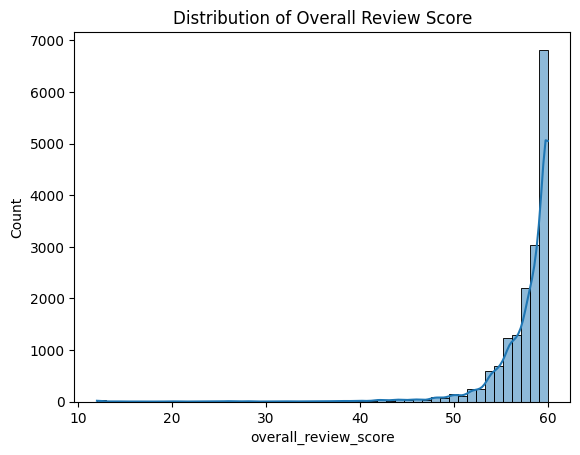

In [16]:
# Check the distribution of overall review score (our target variable)
sns.histplot(data['overall_review_score'], bins=50, kde=True)
plt.title("Distribution of Overall Review Score")
plt.show()

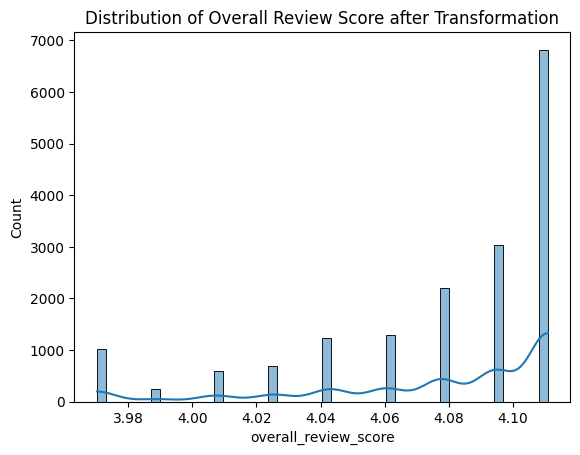

In [17]:
# Calculate upper and lower limits
lower_limit = data["overall_review_score"].quantile(0.05)
upper_limit = data["overall_review_score"].quantile(0.95)

# Cut off outliers
data["overall_review_score"] = np.clip(data["overall_review_score"], lower_limit, upper_limit)

# Apply log1p transformation again
data["overall_review_score"] = np.log1p(data["overall_review_score"])
# Check the distribution of overall review score (our target variable)
sns.histplot(data['overall_review_score'], bins=50, kde=True)
plt.title("Distribution of Overall Review Score after Transformation")
plt.show()

In [18]:
# Process categorical variables: "transit", "notes", "neighborhood_overview", "house_rules"
for col in ["transit", "notes", "neighborhood_overview", "house_rules"]:
    # Assign 1 if the column has text, else 0
    data[col] = data[col].notnull().astype(int)

# Bin them together
data["descriptive_features"] = data[["transit", "notes", "neighborhood_overview", "house_rules"]].sum(axis=1)

# Drop the original columns
data.drop(columns = ["transit", "notes", "neighborhood_overview", "house_rules"], inplace = True)

# Process "summary" and "description" to count the number of characters
data["summary_length"] = data["summary"].fillna("").astype(str).apply(len)
data["description_length"] = data["description"].fillna("").astype(str).apply(len)

# Drop the columns used
data.drop(columns = ['summary', "description"], inplace = True)

# Display the first few rows to verify the changes
print(data[["descriptive_features", "summary_length", "description_length"]].head())

   descriptive_features  summary_length  description_length
0                     4               0                1000
1                     4             232                1000
2                     4             448                1000
3                     4             195                1000
4                     4               0                 958


In [19]:
# Transform 'host_since' into date format
data['host_since'] = pd.to_datetime(data['host_since'], errors='coerce')

# Calculate host duration in days
data['host_duration_days'] = (pd.Timestamp.now() - data['host_since']).dt.days

# Drop the original 'host_since' column (optional)
data = data.drop(columns=['host_since'])

# Transform 'host_response_rate' into numeric format
data['host_response_rate'] = data['host_response_rate'].astype(str)
data['host_response_rate'] = data['host_response_rate'].str.rstrip('%')
data['host_response_rate'] = pd.to_numeric(data['host_response_rate'], errors='coerce')
data['host_response_rate'] = data['host_response_rate'] / 100

# Specify categorical features to create dummy variables for
categorical_features = data.select_dtypes(include=['object', 'category']).columns

# Create dummy variables
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Display the first few rows to verify
print(data.head())
print(categorical_features)

   host_response_rate  accommodates  bathrooms  bedrooms  beds  price  \
0                 0.0             2        1.0       1.0   2.0     60   
1                 0.0             2        1.0       1.0   1.0     35   
2                 1.0             3        1.0       1.0   2.0    159   
3                 0.0             1        1.5       1.0   1.0     50   
4                 1.0             2        1.0       1.0   2.0     69   

   security_deposit  cleaning_fee  guests_included  extra_people  ...  \
0               0.0           0.0                1            22  ...   
1               0.0           9.0                1            15  ...   
2             450.0         100.0                2            28  ...   
3             200.0          15.0                1            20  ...   
4               0.0          15.0                1            20  ...   

   bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
0           False                   False               Tr

In [20]:
# Save the data after cleaning and feature engineering as csv. file
data.to_csv('01_preprocessed_listings_summary.csv', index=False)

## Model Training

In [21]:
# Construct the feature matrix X and target variable y
y = data['overall_review_score']
X = data.drop(columns = ["overall_review_score"])

# Apply scaling to train, validation, and test datasets
scaler = StandardScaler()

# Scale the training set
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Model 1: Linear Regression

Linear Regression Baseline:
Training MSE: 0.001399
Testing MSE: 0.001405
Training R²: 0.160938
Testing R²: 0.164919


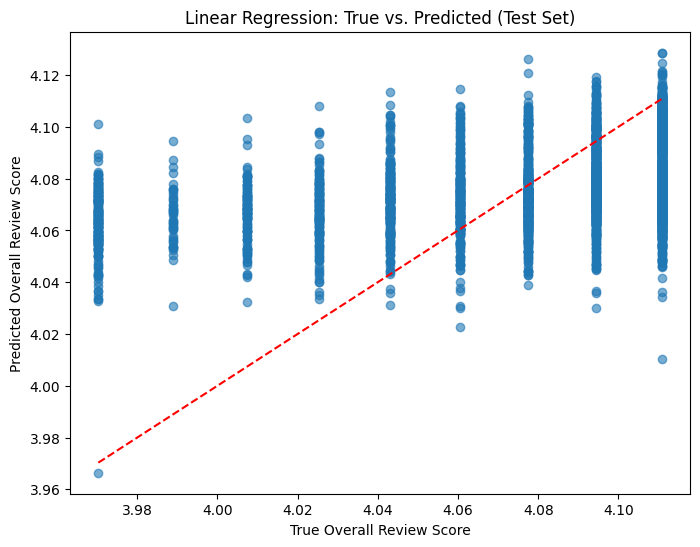

In [22]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Evaluate model performance
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print evaluation metrics
print("Linear Regression Baseline:")
print(f"Training MSE: {mse_train:.6f}")
print(f"Testing MSE: {mse_test:.6f}")
print(f"Training R²: {r2_train:.6f}")
print(f"Testing R²: {r2_test:.6f}")

# Plot predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.xlabel("True Overall Review Score")
plt.ylabel("Predicted Overall Review Score")
plt.title("Linear Regression: True vs. Predicted (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

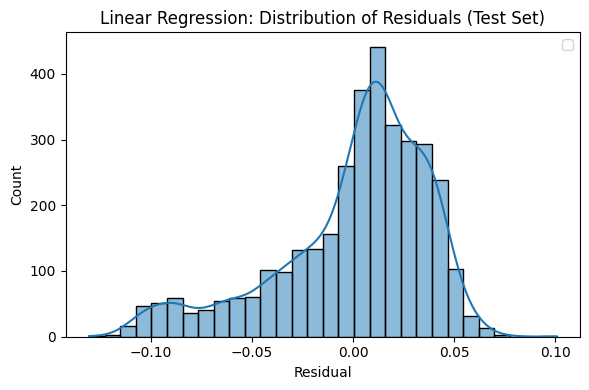

In [23]:
# Residual Analysis
residuals_test = y_test - y_pred_test

plt.figure(figsize=(6, 4))
sns.histplot(residuals_test, kde=True, bins=30)
plt.title("Linear Regression: Distribution of Residuals (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

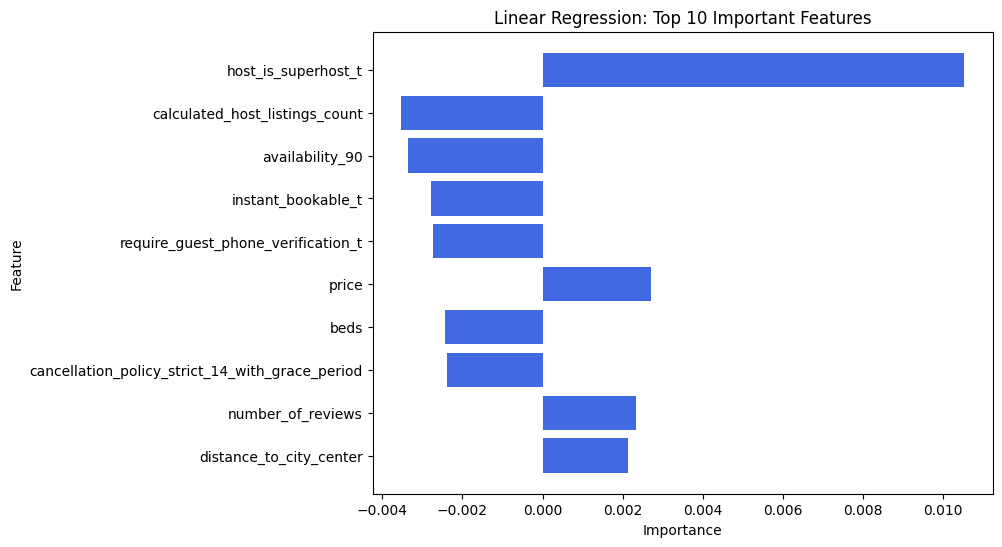

In [24]:
# Feature Importance (Linear Regression Coefficients)
lr_coefficients = lr_model.coef_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_coefficients})

# Sort by absolute value to find the most important features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

# Select the top 10 important features
top_features = feature_importance.head(10)

# Plot Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Linear Regression: Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

### Model 2: ElasticNet Regression

Best Alpha (Regularization Strength): 0.00029763514416313193
Best L1 Ratio (Lasso vs Ridge): 0.8

Final Model Performance:
Train MSE (Best Model): 0.0014030569235381077
Test MSE (Best Model): 0.0014071765295029293
Train R² (Best Model): 0.15861624069775593
Test R² (Best Model): 0.16341066846806285


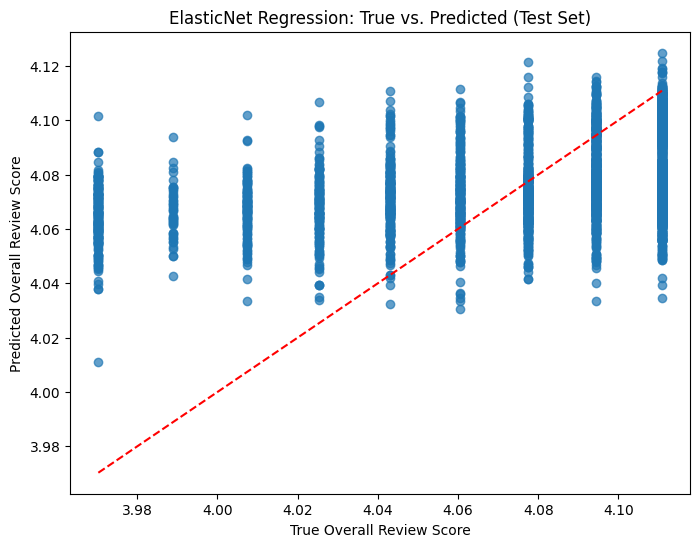

In [25]:
# Train ElasticNet model
# Define candidate parameter ranges
l1_ratios = [0.6, 0.7, 0.8]  # Search space for L1 ratio (balance between Lasso & Ridge)
alphas = np.logspace(-5, 2, 20)  # Log-scale search space for alpha (regularization strength)

# Perform ElasticNet with cross-validation to find optimal hyperparameters
elasticnet_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42)
elasticnet_cv.fit(X_train, y_train)

# Print the best hyperparameters found
print(f"Best Alpha (Regularization Strength): {elasticnet_cv.alpha_}")
print(f"Best L1 Ratio (Lasso vs Ridge): {elasticnet_cv.l1_ratio_}")

# Make predictions
y_pred_train = elasticnet_cv.predict(X_train)
y_pred_test = elasticnet_cv.predict(X_test)

# Evaluate model performance
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print evaluation metrics
print("\nFinal Model Performance:")
print(f"Train MSE (Best Model): {mse_train}")
print(f"Test MSE (Best Model): {mse_test}")
print(f"Train R² (Best Model): {r2_train}")
print(f"Test R² (Best Model): {r2_test}")

# Plot predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel("True Overall Review Score")
plt.ylabel("Predicted Overall Review Score")
plt.title("ElasticNet Regression: True vs. Predicted (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

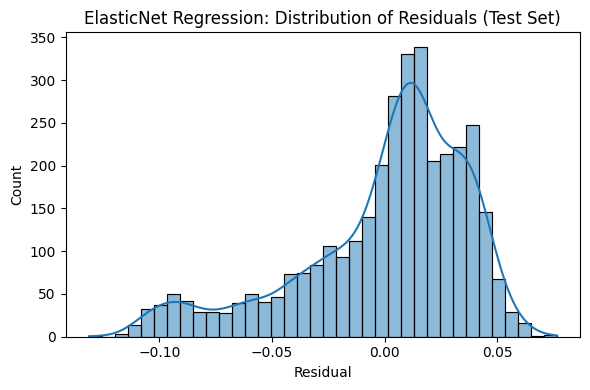

In [26]:
# Plot Distribution of Residuals
residuals_test = y_test - y_pred_test
plt.figure(figsize=(6, 4))
sns.histplot(residuals_test, kde=True)
plt.title("ElasticNet Regression: Distribution of Residuals (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

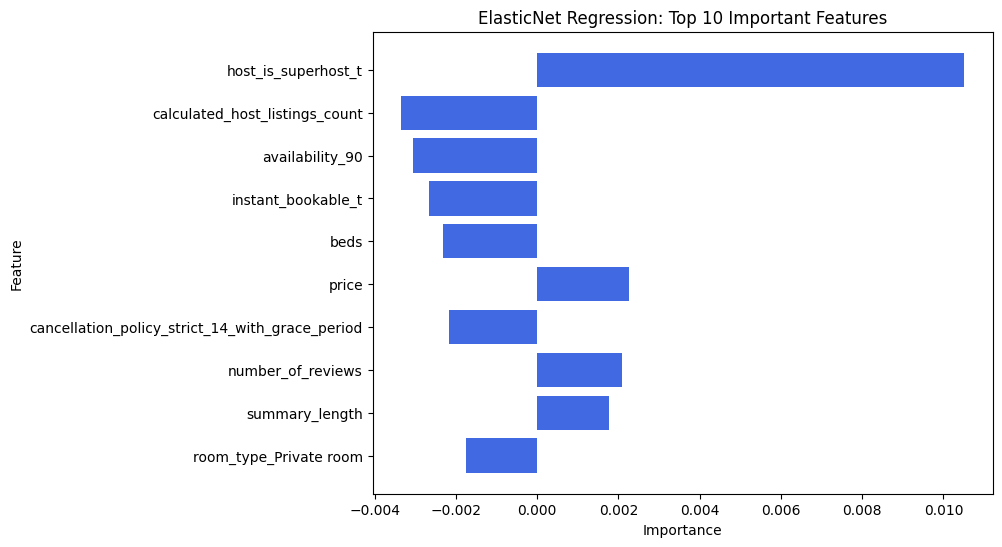

In [27]:
# Get the coefficients of Elastic regression (coefficients)
elasticnet_coefficients = elasticnet_cv.coef_

# Create a DataFrame for easy sorting and visualization
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': elasticnet_coefficients})

# Sort by absolute value to find the most important features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

# Select the top 10 important features
top_features = feature_importance.head(10)

plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("ElasticNet Regression: Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

### Model 3: XGBoost

In [28]:
# Define the optimized parameter search space
param_grid = {
    'n_estimators': [800],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [3, 5]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Use 5-fold cross-validation to balance training efficiency and stability
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# First: Perform Randomized Search to explore a wide range of hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Reduce number of searches to speed up computation
    scoring='r2',
    cv=kfold,
    n_jobs=-1,  # Use all CPU cores for parallel computing
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train, y_train)

# Print the best parameters from RandomizedSearchCV
best_random_params = random_search.best_params_
print("\nBest parameters found from Randomized Search:", best_random_params)
print("Best CV R² score from Randomized Search:", random_search.best_score_)

# Second: Use GridSearchCV to fine-tune around the best learning rate
grid_param = {
    'learning_rate': [
        best_random_params['learning_rate'] * 0.5,
        best_random_params['learning_rate'],
        best_random_params['learning_rate'] * 1.5
    ]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, **best_random_params),
    param_grid=grid_param,
    scoring='r2',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Evaluate the Tuned Model on the Test Set
best_model = grid_search.best_estimator_

# Predictions on the Test Set
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Predictions on the Training Set
y_pred_train = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Test MSE (Best XGBoost Model):", mse_test)
print("Test R2 (Best XGBoost Model):", r2_test)
print("Train MSE (Best XGBoost Model):", mse_train)
print("Train R2 (Best XGBoost Model):", r2_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found from Randomized Search: {'subsample': 0.7, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV R² score from Randomized Search: 0.21237308613559924
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Test MSE (Best XGBoost Model): 0.0012916017314967385
Test R2 (Best XGBoost Model): 0.23212176546176566
Train MSE (Best XGBoost Model): 0.001118392367759818
Train R2 (Best XGBoost Model): 0.32932359409355383


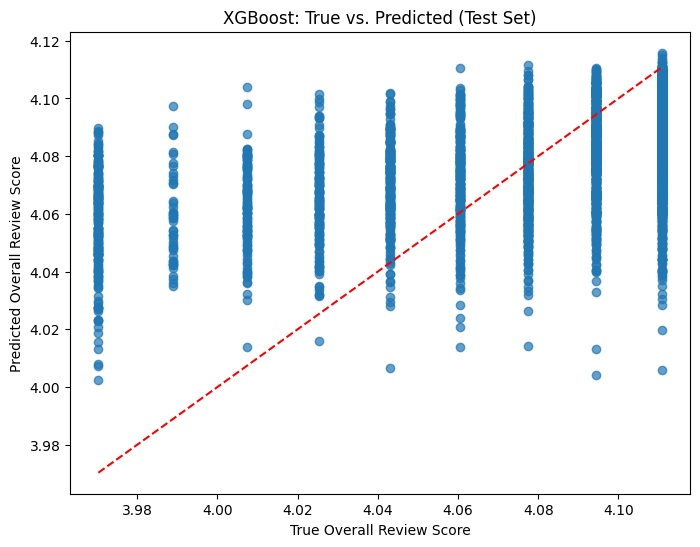

In [29]:
# Plot Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel("True Overall Review Score")
plt.ylabel("Predicted Overall Review Score")
plt.title("XGBoost: True vs. Predicted (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

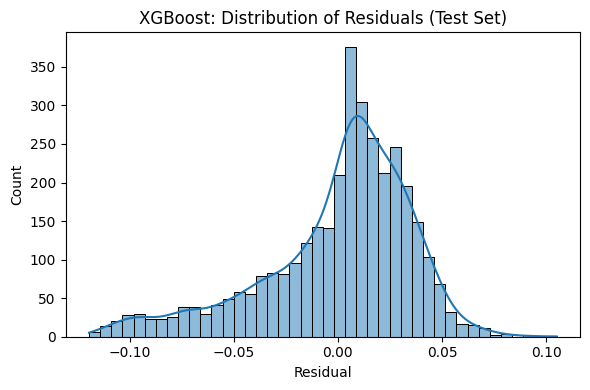

In [30]:
# Plot Distribution of Residuals
residuals_test = y_test - y_pred_test
plt.figure(figsize=(6, 4))
sns.histplot(residuals_test, kde=True)
plt.title("XGBoost: Distribution of Residuals (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

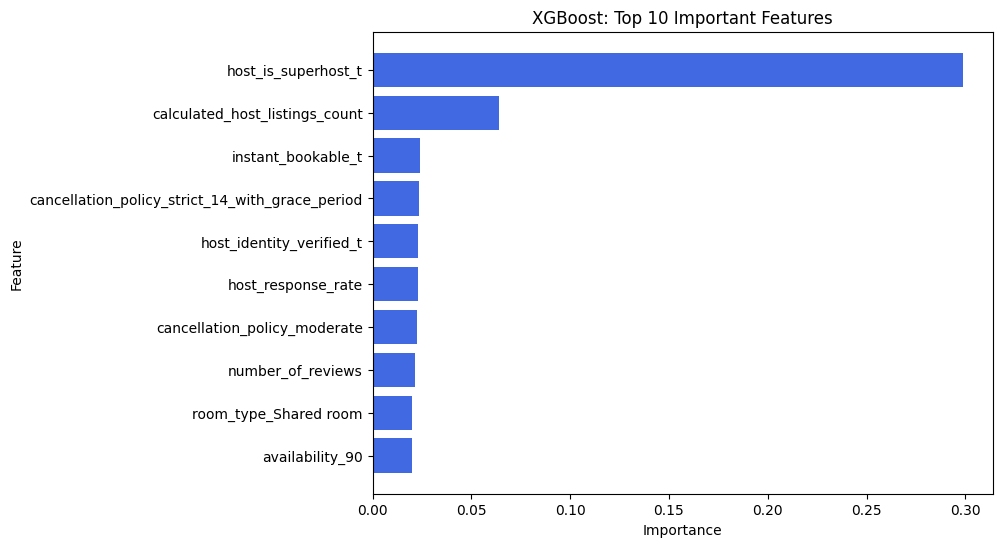

In [31]:
# Plot Feature Importances
importances = best_model.feature_importances_
feature_names = X.columns

# Sort by importance (descending)
indices = np.argsort(importances)[::-1]

# Choose how many top features you want to show
top_n = 10
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_names[top_indices], importances[top_indices], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost: Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

### Model 4: Random Forest

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)

grid_search = GridSearchCV(
    rf, param_grid=param_grid,
    cv=cv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_
# Predictions on the Test Set
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Predictions on the Training Set
y_pred_train = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Test MSE (Best Random Forest Model):", mse_test)
print("Test R2 (Best Random Forest Model):", r2_test)
print("Train MSE (Best Random Forest Model):", mse_train)
print("Train R2 (Best Random Forest Model):", r2_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 300}
Test MSE (Best Random Forest Model): 0.0012909455041992585
Test R2 (Best Random Forest Model): 0.232511903262263
Train MSE (Best Random Forest Model): 0.000818048057669188
Train R2 (Best Random Forest Model): 0.5094337667242151


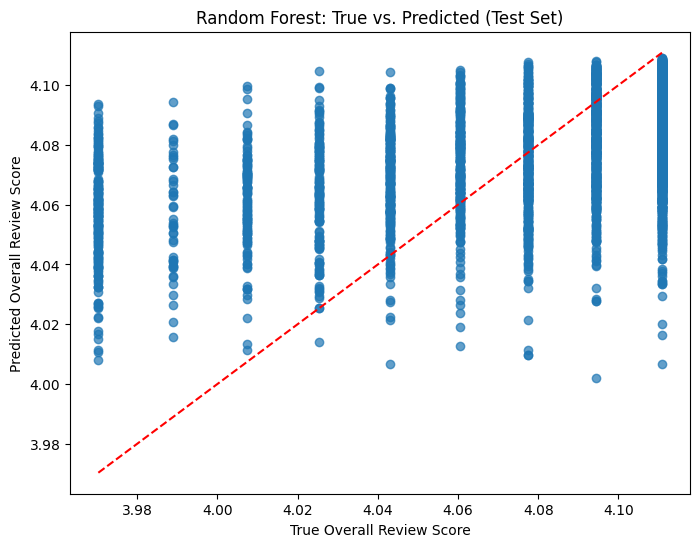

In [33]:
# Plot Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel("True Overall Review Score")
plt.ylabel("Predicted Overall Review Score")
plt.title("Random Forest: True vs. Predicted (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

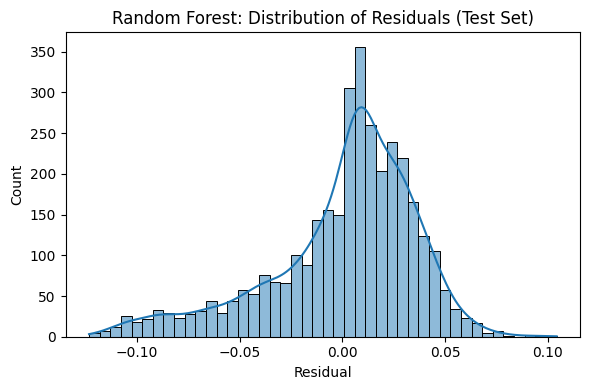

In [34]:
# Plot Distribution of Residuals
residuals_test = y_test - y_pred_test
plt.figure(figsize=(6, 4))
sns.histplot(residuals_test, kde=True)
plt.title("Random Forest: Distribution of Residuals (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

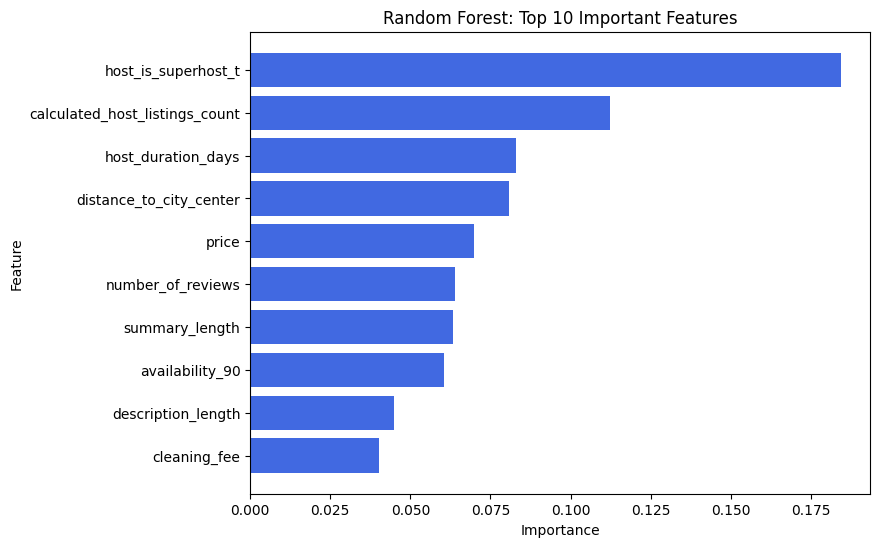

In [35]:
# Plot Feature Importances
importances = best_model.feature_importances_
feature_names = X.columns

# Sort by importance (descending)
indices = np.argsort(importances)[::-1]

# Choose how many top features you want to show
top_n = 10
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_names[top_indices], importances[top_indices], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest: Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()